In [82]:
function Deltastep(list,s,delta)
    @everywhere rdc(d::Vector,i::Vector) = rdc(rdc(Dict(),d),i)
    @everywhere rdc(d::Dict,i::Vector) = begin d[i[1]] = []; d[i[2]] = [];d end
    @everywhere rdc(d::Dict,i::Dict) = merge!(d,i)
    
    
    @everywhere rdt(d::Vector,i::Vector) = rdt(rdt(Dict(),d),i)
    @everywhere rdt(d::Dict,i::Vector) = begin d[i[1]] = 1000000000000000;d[i[2]] = 1000000000000000; d end
    @everywhere rdt(d::Dict,i::Dict) = merge!(d,i)
    
    @everywhere rdcc(d::Vector,i::Vector) = rdcc(rdcc(Dict(),d),i)
    @everywhere rdcc(d::Dict,i::Vector) = begin d[i[1],i[2]] = i[3]; d end
    @everywhere rdcc(d::Dict,i::Dict) = merge!(d,i)
    
    @everywhere rds(d::Vector,i::Vector) = rds(rds(Set(),d),i)
    @everywhere rds(d::Set,i::Vector) = begin push!(d,i[1]);push!(d,i[2]); d end
    @everywhere rds(d::Set,i::Set) = union!(d,i)
    
    @everywhere rde(d::Vector,i::Vector) = rde(rde(Set(),d),i)
    @everywhere rde(d::Set,i::Vector) = begin push!(d,[i[1],i[2]]); d end
    @everywhere rde(d::Set,i::Set) = union!(d,i)
   
    
    heavy = @parallel (rdc) for item in list
      item;
    end

    light=@parallel (rdc) for item in list
        item;
    end
    
    tent= @parallel (rdt) for item in list 
        item;
    end
    
    pred= @parallel (rdt) for item in list 
        item;
    end
    
    C = @parallel (rdcc) for item in list 
        item
    end
    
    V = @parallel (rds) for item in list
    item
    end
    E= @parallel (rde) for item in list 
        item 
    end
    
    B=Dict{Any,Set}()
   
    Req=[]
    
    # println("Heavy: $heavy ")
    # println("C=$C")

    for e in E
        v=e[1]
        w=e[2]
        if C[v,w]>delta
            push!(heavy[v],e)
        else
            push!(light[v],e)
        end
    end
    
    # println("Light: $light  ")
    # println("E=$E")
    relax(s,0,delta,B,tent,pred,1000000000)
    i=0
    while isempty(B)==false
        # println("B=$B")
        # println("tent=$tent")
        # Processing vertices from B[i]
        if haskey(B,i)==true
            S=Set()
            # Relax recursively all light edges while they stay in B[i]
            while isempty(B[i])==false
                # Push to Req all light edges from vertices in B[i]
                Req=[]
                for v in B[i]
                    # println("v=$v")
                    for e in light[v]
                        # println("e=$e")
                        push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                    end
                end
                # Update S
                union!(S,B[i])
                B[i]=Set()
                
                # Relax all Req edges
                for r in Req
                    # println("r=$r")
                    relax(r[1],r[2],delta,B,tent,pred,r[3])
                end
            end
            # Relax all heavy edges of vertices in S
            Req=[]
            delete!(B,i)
            for v in S
                for e in heavy[v]
                    push!(Req,[e[2],tent[v]+C[e[1],e[2]],v])
                end
            end
            for r in Req
                relax(r[1],r[2],delta,B,tent,pred,r[3])
            end
        end
        
        i=i+1
    end
    
    println("This is the answer: $tent")
  
    return tent,pred
    
   
end

Deltastep (generic function with 1 method)

In [68]:
function relax(w,d,delta,B,tent,pred,v)
    # println("w : $w")
    
    if d<tent[w]
        old_i=floor(tent[w]/delta)
        tent[w]=d
        
        if (haskey(B,old_i)==true)
            delete!(B[old_i],w)
            
        else
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), B[old_i=$old_i] not found")
        end
        #Add w to new bin and update its tent
        new_i=floor(d/delta)
        if (haskey(B,new_i)==false)
            B[new_i]=Set()
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), allocated B[fld=$new_i].")
        end
        push!(B[new_i],w)
        tent[w]=d
        if (haskey(pred,w)==false)
            pred[w]=()
            pred[w]=v
            # println("Warning: In relax (w=$w,d=$d,delta=$delta), allocated B[fld=$new_i].")
        else 
            pred[w]=v
        end
        
        # println("The previous node visited was: $pred")
    end
end
        

relax (generic function with 1 method)

In [69]:
function setup(A)
    node=Array{Int64}[]
	x,y = size(A)
	list=Array{Float64}[]
	A=convert(Image{Gray{Ufixed8}}, A)
    xx,yy=imgradients(img)
    c=(sqrt(xx.^2+yy.^2))
    cost=1./(c.+1)
    
	for i in x:length(A)-x
		
    color1=colordiff(color(A[i]),color(A[i+1]))+1
    edge=[i,i+1,color1]
    push!(list,edge)
    color1=colordiff(color(A[i]),color(A[i-1]))+1
    edge=[i,i-1,color1]
    push!(list,edge)
    color1=colordiff(color(A[i]),color(A[i-y]))+1
    edge=[i,i-y,color1]
    push!(list,edge)
    color1=colordiff(color(A[i]),color(A[i+y]))+1
    edge=[i,i+y,color1]
    push!(list,edge)
    color1=colordiff(color(A[i]),color(A[i-y-1]))+1
    edge=[i,i-y-1,color1]
    push!(list,edge)
    color1=colordiff(color(A[i]),color(A[i-y+1]))+1
    edge=[i,i-y+1,color1]
    push!(list,edge)
    color1=colordiff(color(A[i]),color(A[i+y-1]))+1
    edge=[i,i+y-1,color1]
    push!(list,edge)
    color1=colordiff(color(A[i]),color(A[i+y+1]))+1
    edge=[i,i+y+1,color1]
    push!(list,edge)
    
	end

return list





end


setup (generic function with 1 method)

In [70]:
function path(pred,w)
  v=w
  path = []
  while v<1000000000
        push!(path,v)
        #println("$path")
        v = pred[v]
   end
    
  return path
end

path (generic function with 1 method)

  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /Users/mac/.julia/v0.4/ImageView/src/annotations.jl:61
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/mac/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/mac/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading /Users/mac/.julia/v0.4/ImageView/src/annotations.jl, in expression starting on line 96
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in i

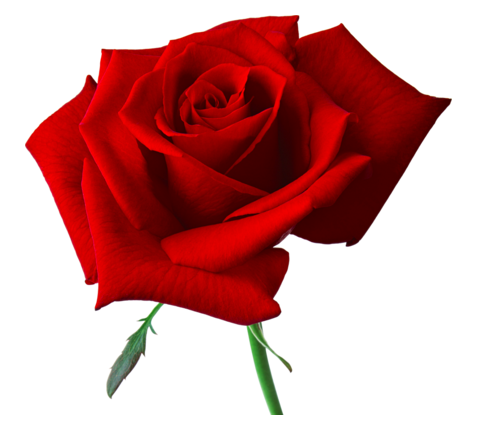

In [6]:
using Images, Colors, FixedPointNumbers, ImageView
img=load("rose.png")

In [8]:
L=setup(img)

  likely near In[8]:1
  likely near In[8]:1


1700832-element Array{Array{Float64,N},1}:
 [491.0,492.0,1.0]      
 [491.0,490.0,1.0]      
 [491.0,56.0,1.0]       
 [491.0,926.0,1.0]      
 [491.0,55.0,1.0]       
 [491.0,57.0,1.0]       
 [491.0,925.0,1.0]      
 [491.0,927.0,1.0]      
 [492.0,493.0,1.0]      
 [492.0,491.0,1.0]      
 [492.0,57.0,1.0]       
 [492.0,927.0,1.0]      
 [492.0,56.0,1.0]       
 ⋮                      
 [213093.0,212657.0,1.0]
 [213093.0,212659.0,1.0]
 [213093.0,213527.0,1.0]
 [213093.0,213529.0,1.0]
 [213094.0,213095.0,1.0]
 [213094.0,213093.0,1.0]
 [213094.0,212659.0,1.0]
 [213094.0,213529.0,1.0]
 [213094.0,212658.0,1.0]
 [213094.0,212660.0,1.0]
 [213094.0,213528.0,1.0]
 [213094.0,213530.0,1.0]

In [16]:
L[9116:9120]

5-element Array{Array{Float64,N},1}:
 [1630.0,2065.0,1.0]
 [1630.0,1194.0,1.0]
 [1630.0,1196.0,1.0]
 [1630.0,2064.0,1.0]
 [1630.0,2066.0,1.0]

In [71]:
graph=Array{Int64}[]
push!(graph,[1,2,1])
push!(graph,[2,3,1])
push!(graph,[3,1,4])
push!(graph,[3,4,2])
push!(graph,[4,2,5])


5-element Array{Array{Int64,N},1}:
 [1,2,1]
 [2,3,1]
 [3,1,4]
 [3,4,2]
 [4,2,5]

In [89]:

@time Deltastep(graph,1,1)

E=Set(Any[[3,1],[1,2],[4,2],[3,4],[2,3]])
E=Set(Any[[3,1],[1,2],[4,2],[3,4],[2,3]])
Heavy: Dict{Any,Any}(4=>Any[],2=>Any[],3=>Any[],1=>Any[]) 
This is the answer: Dict{Any,Any}(4=>4,2=>1,3=>2,1=>0)
  0.147577 seconds (60.76 k allocations: 4.609 MB)


(Dict{Any,Any}(4=>4,2=>1,3=>2,1=>0),Dict{Any,Any}(4=>3,2=>1,3=>2,1=>1000000000))

In [6]:
list = [[rand(1:3),4,5] for i=1:100]; # define random test `list`

@everywhere rdc(d::Vector,i::Vector) = rdc(rdc(Dict(),d),i)
@everywhere rdc(d::Dict,i::Vector) = begin d[i[1]] = 1000; d end
@everywhere rdc(d::Dict,i::Dict) = merge!(d,i)

heavy = @parallel (rdc) for item in list
  item
end

Dict{Any,Any} with 3 entries:
  2 => 1000
  3 => 1000
  1 => 1000

In [2]:
heavy[1]

1000

In [14]:
addprocs()

4-element Array{Int64,1}:
 6
 7
 8
 9

In [6]:
list = [[rand(1:7),8,5] for i=1:100]; # define random test `list`

@everywhere rdc(d::Vector,i::Vector) = rdc(rdc(Dict(),d),i)
@everywhere rdc(d::Dict,i::Vector) = begin d[i[1]] = [];d[i[2]] = [] ; d end
@everywhere rdc(d::Dict,i::Dict) = merge!(d,i)

heavy = @parallel (rdc) for item in list
    item
end

LoadError: LoadError: StackOverflowError:
 in zeros at ./array.jl:211
 in rdc at In[6]:3 (repeats 99 times)
while loading In[6], in expression starting on line 7

In [35]:
heavy

Pair{Any,Any}(7,Any[])

In [38]:
heavy[1]

0-element Array{Any,1}

In [38]:
@everywhere V=Set()
@everywhere function pushing(item)
    push!(V,item[1])
end

In [43]:
a=pmap(pushing,graph)

5-element Array{Any,1}:
 Set(Any[4,1])
 Set(Any[2])  
 Set(Any[3])  
 Set(Any[3])  
 Set(Any[4,1])

In [16]:
addprocs()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [59]:
V=Set()
@sync @parallel for item in graph 
    push!(V,item[1])
end

4-element Array{Any,1}:
 RemoteRef{Channel{Any}}(2,1,114)
 RemoteRef{Channel{Any}}(3,1,115)
 RemoteRef{Channel{Any}}(4,1,116)
 RemoteRef{Channel{Any}}(5,1,117)

In [60]:
V

Set{Any}()

In [56]:
V[4]

3

In [74]:
list = [[rand(1:3),8,10] for i=1:100]; # define random test `list`   
@everywhere rds(d::Vector,i::Vector) = rds(rds(Set(),d),i)
@everywhere rds(d::Set,i::Vector) = begin push!(d,i[1]);push!(d,i[2]); d end
@everywhere rds(d::Set,i::Set) = union!(d,i)
heavy = @parallel (rds) for item in list
    item
end

Set(Any[2,3,8,1])

In [85]:
nprocs()


5